In [35]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
l = np.arange(-180,180,1)
b = np.arange(-90,90,1)
l_grid, b_grid = np.meshgrid(l, b)
c = SkyCoord(l=l_grid*u.degree, b=b_grid*u.degree, frame='galactic')
l_arr = l_grid.flatten()
b_arr = b_grid.flatten()

#the map is in (ra,dec) so we need to convert:
ra = c.icrs.ra.degree.flatten() 
dec = c.icrs.dec.degree.flatten() 

In [3]:
def plot_completeness(l, b, completeness, title=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter( l, b, c=completeness , vmin=0.8, vmax=1,s=1)
    plt.colorbar(label='completeness')
    plt.xlim(180,-180)
    plt.ylim(-90, 90)
    plt.xlabel('l (degrees)')
    plt.ylabel('b (degrees)')
    plt.show()

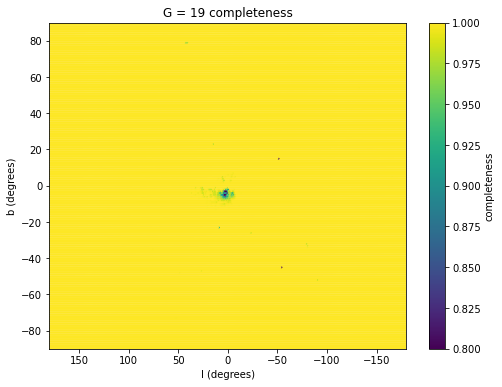

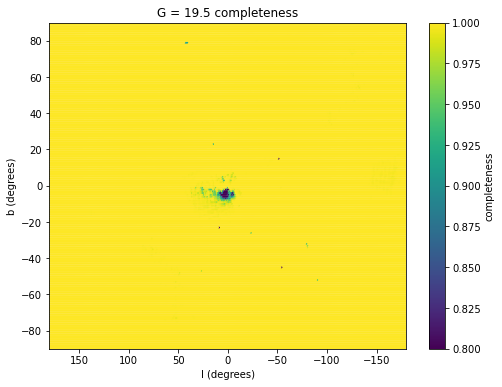

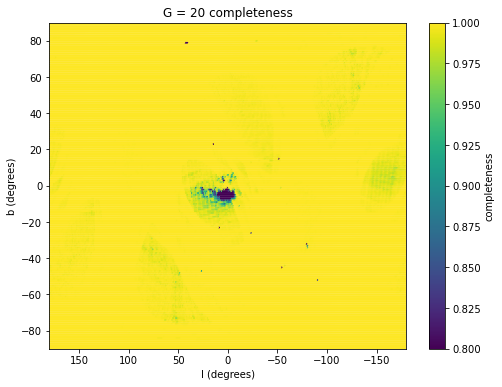

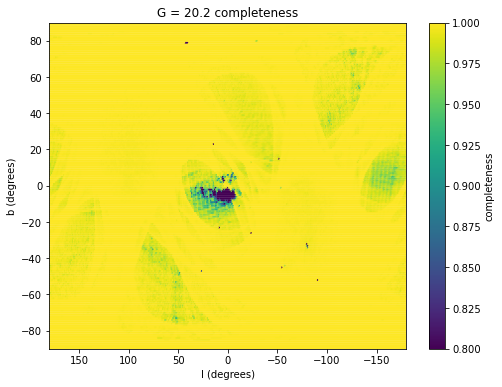

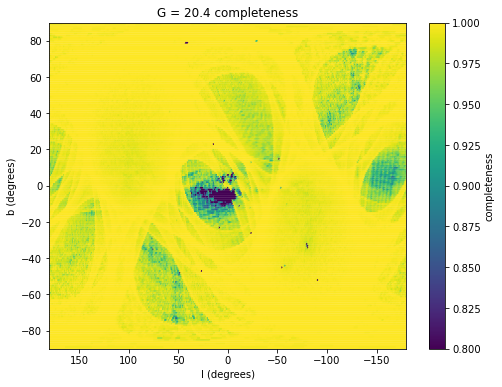

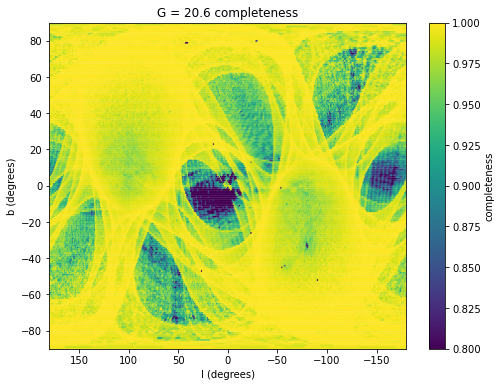

In [4]:
gmag_lims = [19, 19.5, 20, 20.2, 20.4, 20.6]
for gmag in gmag_lims:
    completeness = utils.get_completeness(ra, dec, gmag)
    title = f'G = {gmag} completeness'
    plot_completeness(l_arr, b_arr, completeness, title=title)

## Load in data

In [23]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [24]:
map_nqso_data, pixel_indices_data = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

0.0 180.0 -180.0 180.0


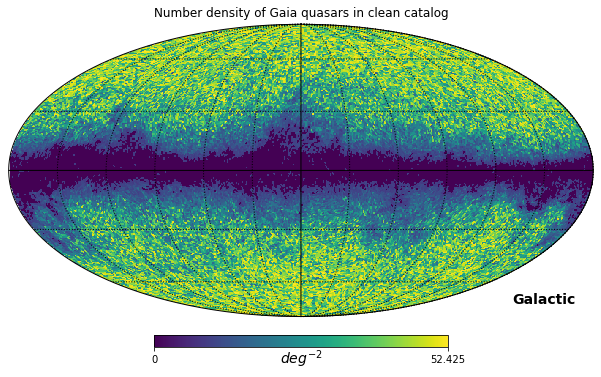

In [25]:
hp.mollview(
    map_nqso_data/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

In [29]:
b_max = 10
mask_func_args = [b_max]
mask_func = masks.galactic_plane_mask
ra_data_plane, dec_data_plane = generate_random.subsample_by_mask(NSIDE, ra_data, dec_data, mask_func, mask_func_args)

Masked 0.988 of sources


In [30]:
map_nqso_data_plane, pixel_indices_data_plane = utils.get_map(NSIDE, ra_data_plane, dec_data_plane, null_val=0)

0.0 180.0 -180.0 180.0


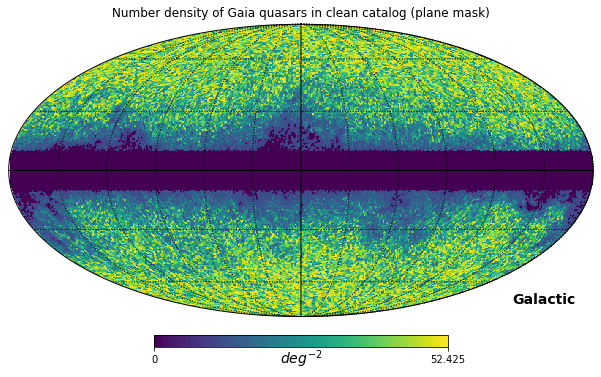

In [31]:
hp.mollview(
    map_nqso_data_plane/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

## Load in randoms

In [5]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [6]:
tab_rcomp = utils.load_table(f'../data/randoms/random_completeness_10x.fits')

In [8]:
map_nqso_rcomp, pixel_indices_randcomp = utils.get_map(NSIDE, tab_rcomp['ra'], tab_rcomp['dec'], null_val=0)

0.0 180.0 -180.0 180.0


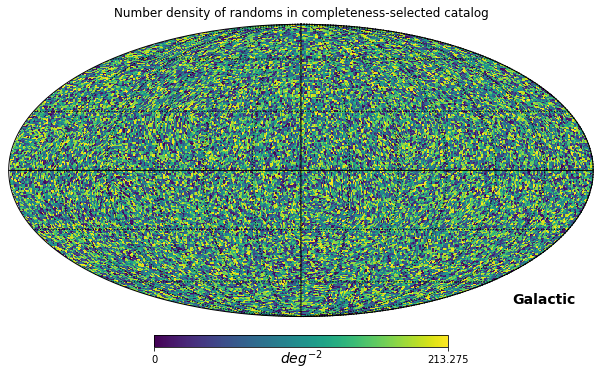

In [9]:
hp.mollview(
    map_nqso_rcomp/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

In [20]:
tab_rdustcompplane = utils.load_table('../data/randoms/random_dust_completeness_maskplane_10x.fits')

In [21]:
map_nqso_rdustcompplane, _ = utils.get_map(NSIDE, tab_rdustcompplane['ra'], tab_rdustcompplane['dec'], null_val=0)

0.0 180.0 -180.0 180.0


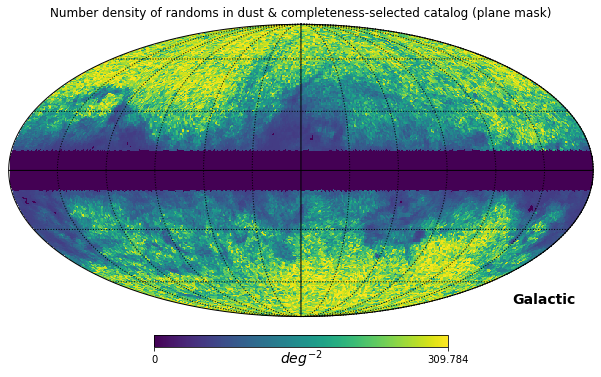

In [32]:
hp.mollview(
    map_nqso_rdustcompplane/area_per_pixel,
    title=rf"Number density of randoms in dust & completeness-selected catalog (plane mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

In [14]:
import masks
mask = masks.galactic_plane_mask(64, 10)

In [33]:
nbins = 14
theta_edges = np.linspace(0.5, 4, nbins + 1)
theta_avg = 10**(0.5*(np.log10(theta_edges[:-1]) + np.log10(theta_edges[1:])))
print(theta_edges)

[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.  ]


In [37]:
wtheta_plane, dd_plane, _, _, = correlations.compute_wtheta(theta_edges, ra_data, dec_data, 
                                               tab_rdustcompplane['ra'], tab_rdustcompplane['dec'], 
                                               return_full_results=True)

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 2.2307 s
Time: 40.1015 s
Time: 175.9578 s


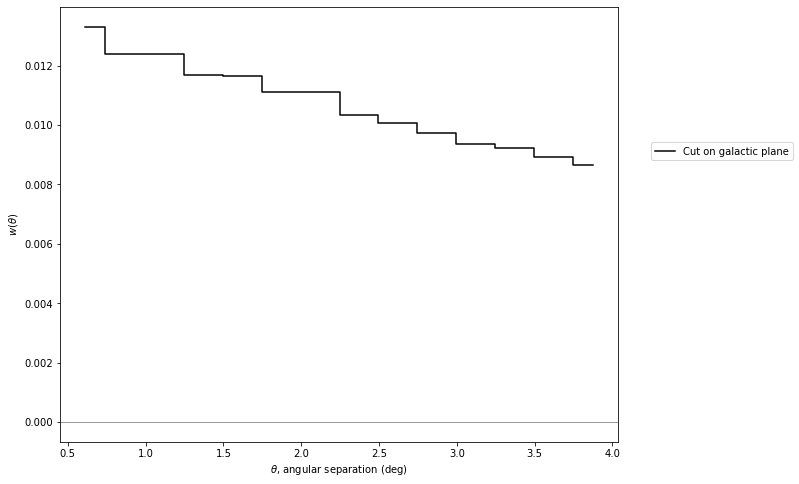

In [38]:
plt.figure(figsize=(10,8))
plt.step(theta_avg, wtheta_plane, where='mid', label=rf'Cut on galactic plane', color='k')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))

In [40]:
nbins = 15
theta_edges_log = np.logspace(-1, 1, nbins + 1)
theta_avg_log = 10**(0.5*(np.log10(theta_edges_log[:-1]) + np.log10(theta_edges_log[1:])))
print(theta_edges_log)

[ 0.1         0.13593564  0.18478498  0.25118864  0.34145489  0.46415888
  0.63095734  0.8576959   1.1659144   1.58489319  2.15443469  2.92864456
  3.98107171  5.41169527  7.35642254 10.        ]


In [41]:
wtheta_plane_log, dd_plane_log, _, _, = correlations.compute_wtheta(theta_edges_log, ra_data, dec_data, 
                                               tab_rdustcompplane['ra'], tab_rdustcompplane['dec'], 
                                               return_full_results=True)

Time: 7.4688 s
Time: 158.4117 s
Time: 949.5911 s


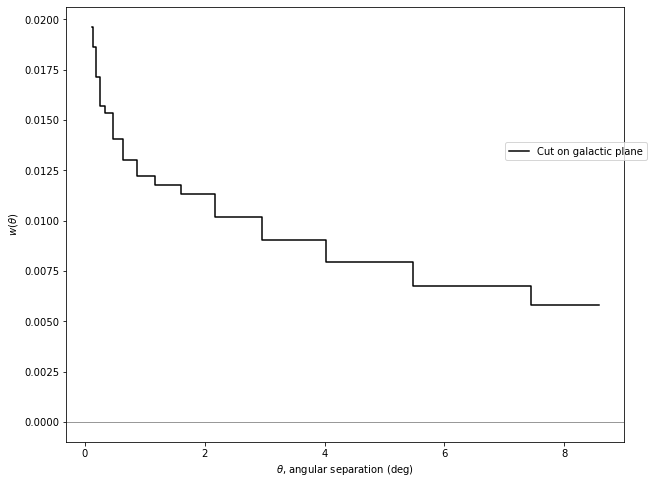

In [42]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, wtheta_plane_log, where='mid', label=rf'Cut on galactic plane', color='k')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))